In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv('../data/processed/cleaned_netflix_customer_churn.csv')


print(df.head())
print(df.info())
print(df.describe())
print(df.describe(include='object'))
print(df.duplicated().sum())

   age  gender subscription_type  watch_hours  last_login_days   region  \
0   51   Other             Basic        14.73               29   Africa   
1   47   Other          Standard         0.70               19   Europe   
2   27  Female          Standard        16.32               10     Asia   
3   53   Other           Premium         4.51               12  Oceania   
4   56   Other          Standard         1.89               13   Africa   

   device  churned payment_method  number_of_profiles  avg_watch_time_per_day  \
0      TV        1      Gift Card                   1                    0.49   
1  Mobile        1      Gift Card                   5                    0.03   
2      TV        0         Crypto                   2                    1.48   
3      TV        1         Crypto                   2                    0.35   
4  Mobile        1         Crypto                   2                    0.13   

  favorite_genre  
0         Action  
1         Sci-Fi  
2    

In [24]:
#Define unique and categorical columns

numeric_features=[feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features=[feature for feature in df.columns if df[feature].dtype == 'O']

print(f"NUMERICAL FEATURES ARE: {len(numeric_features)} -> {numeric_features}")
print(f"CATEGORICAL FEATURES ARE: {len(categorical_features)} -> {categorical_features}")

# Remove target column
if 'churned' in numeric_features:
    numeric_features.remove('churned')

NUMERICAL FEATURES ARE: 6 -> ['age', 'watch_hours', 'last_login_days', 'churned', 'number_of_profiles', 'avg_watch_time_per_day']
CATEGORICAL FEATURES ARE: 6 -> ['gender', 'subscription_type', 'region', 'device', 'payment_method', 'favorite_genre']


TARGET CHURN DISTRIBUTION


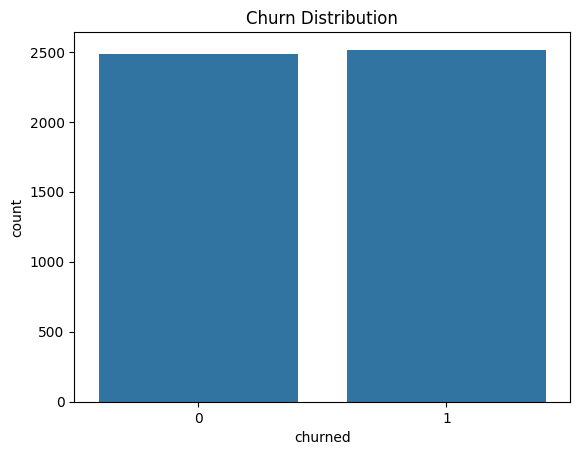

churned
1    50.3
0    49.7
Name: proportion, dtype: float64

In [25]:
sns.countplot(x='churned',data=df)
plt.title('Churn Distribution')
plt.show()

df['churned'].value_counts(normalize=True)*100

Churn compare with numerical features

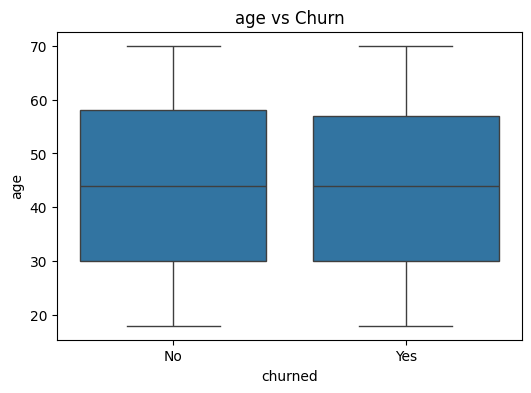

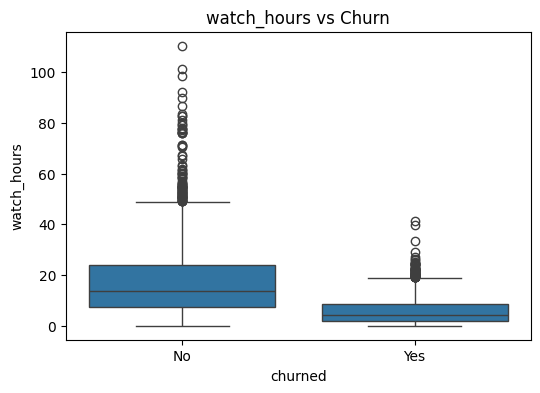

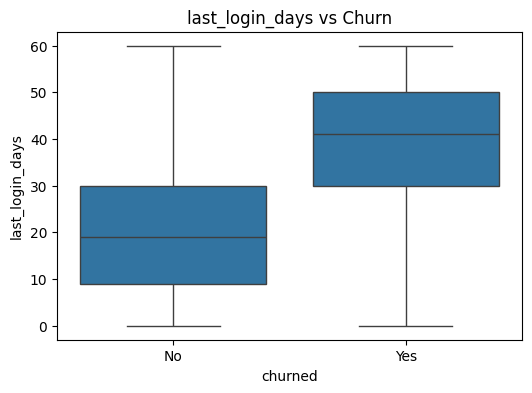

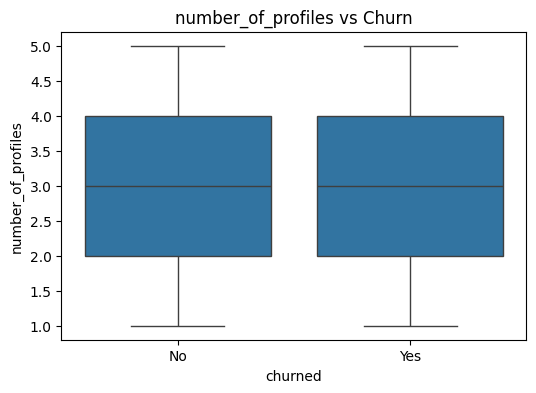

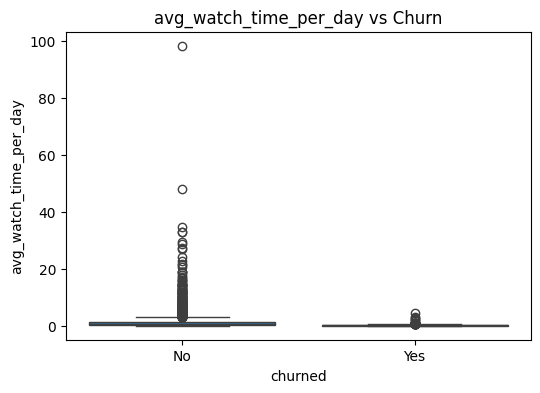

In [26]:
from matplotlib.backends.backend_pdf import PdfPages


with PdfPages("all_boxplots.pdf") as pdf:
    for col in numeric_features:
        plt.figure(figsize=(6,4))
        sns.boxplot(x='churned', y=col, data=df)
        plt.title(f"{col} vs Churn")
        plt.xticks([0, 1], ['No', 'Yes'])
        pdf.savefig()   # save before closing
        plt.show()


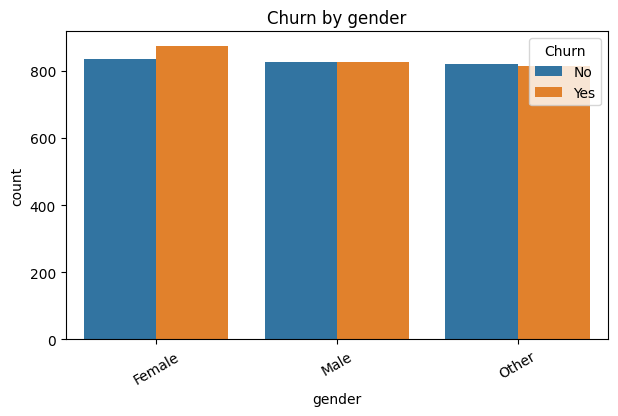

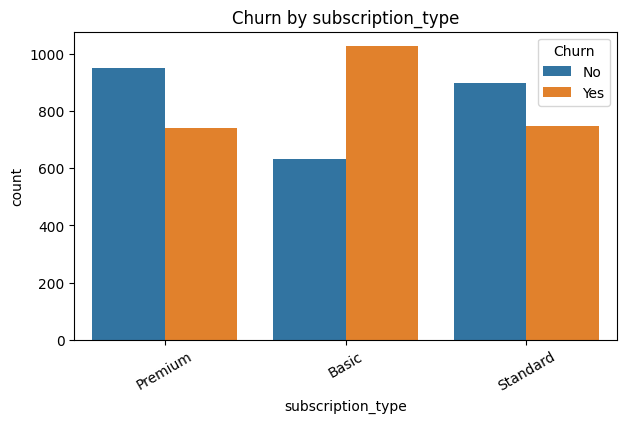

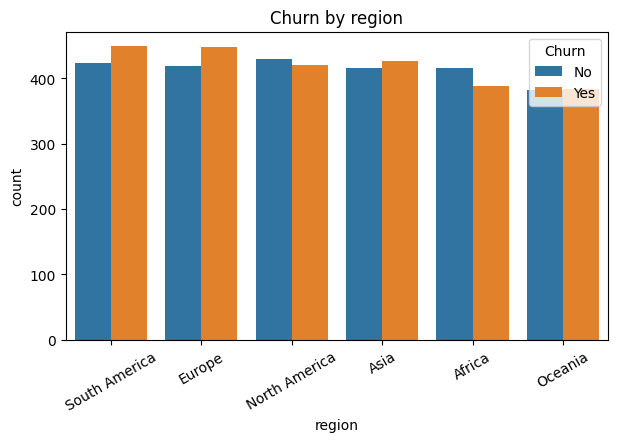

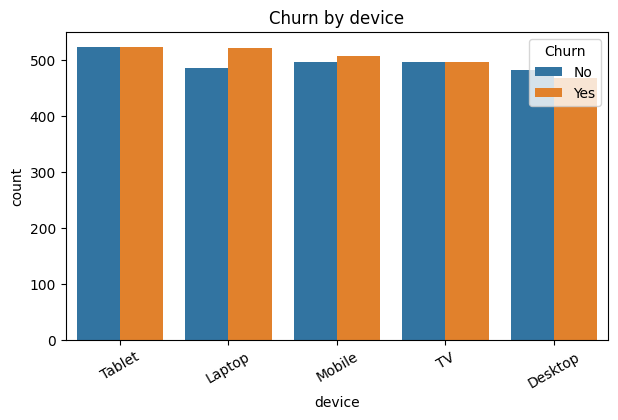

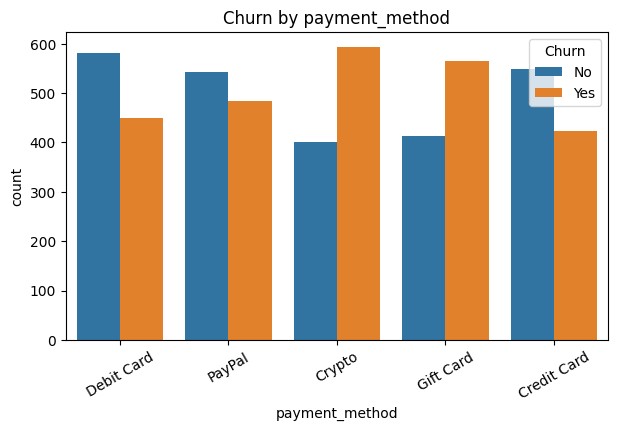

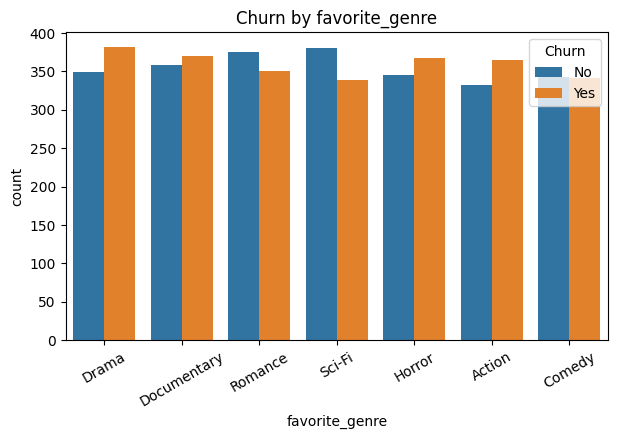

In [27]:
from matplotlib.backends.backend_pdf import PdfPages


with PdfPages("all_boxplots_category.pdf") as pdf:
    for col in categorical_features:
     plt.figure(figsize=(7,4))
     sns.countplot(x=col, hue="churned", data=df, order=df[col].value_counts().index)

     plt.title(f"Churn by {col}")
     plt.xticks(rotation=30)
     plt.legend(title="Churn", labels=["No", "Yes"])

     plt.savefig("all_boxplots_category.pdf")
     plt.show()

In [28]:
import numpy as np

# IQR method for capping
Q1 = df['watch_hours'].quantile(0.25)
Q3 = df['watch_hours'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# Create capped version
df['watch_hours_capped'] = df['watch_hours'].clip(lower=lower_bound, upper=upper_bound)

# Create log-transformed version
df['watch_hours_log'] = np.log1p(df['watch_hours'])   # log(1+x) avoids log(0)


**Capping outliers**

We don’t want to delete those rows. Instead, we cap them.

If someone’s watch hours > upper_bound → we replace it with upper_bound.

If < lower_bound → we replace it with lower_bound.

That’s what .clip() does

**Log transformation**

Another way: compress big numbers so they don’t look so huge compared to small numbers.

We take the logarithm (like in math, log(1000) is much smaller than 1000).

But since log(0) is undefined, we use log1p(x) → which means log(1+x).

This makes another new column watch_hours_log, where the data is less skewed.

In [29]:
Q1 = df['avg_watch_time_per_day'].quantile(0.25)
Q3 = df['avg_watch_time_per_day'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

#Capped version
df['avg_watch_time_per_day_capped'] = df['avg_watch_time_per_day'].clip(lower=lower_bound, upper=upper_bound)


In [30]:
#Logged version
import numpy as np
df['avg_watch_time_per_day_log'] = np.log1p(df['avg_watch_time_per_day'])


In [31]:
#Feature engineering
df['avg_watch_time_per_profile'] = df['avg_watch_time_per_day'] / df['number_of_profiles']


In [32]:
#Since subscription type already corresponds to a monthly fee, we can replace category with price:

mapping = {"Basic": 8.99, "Standard": 13.99, "Premium": 17.99}
df['subscription_price'] = df['subscription_type'].map(mapping)


In [33]:
# One-hot encode payment_method
df = pd.get_dummies(df, columns=['payment_method'], drop_first=True)

print(df.columns)

Index(['age', 'gender', 'subscription_type', 'watch_hours', 'last_login_days',
       'region', 'device', 'churned', 'number_of_profiles',
       'avg_watch_time_per_day', 'favorite_genre', 'watch_hours_capped',
       'watch_hours_log', 'avg_watch_time_per_day_capped',
       'avg_watch_time_per_day_log', 'avg_watch_time_per_profile',
       'subscription_price', 'payment_method_Crypto',
       'payment_method_Debit Card', 'payment_method_Gift Card',
       'payment_method_PayPal'],
      dtype='object')


In [34]:
# 1. Drop only weak/redundant columns
cols_to_drop = ['age', 'gender', 'subscription_type']
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

# 2. One-hot encode the remaining categorical features
df = pd.get_dummies(df, columns=['region', 'device', 'favorite_genre'], drop_first=True)

# 3. Define Features (X) and Target (y)
X = df.drop(columns=['churned'])
y = df['churned']

# 4. Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (4000, 29)
Test size: (1000, 29)


**LOGISTIC REGRESSION**

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Initialize Logistic Regression
# class_weight='balanced' handles class imbalance if churned customers are fewer
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# 2. Train the model
log_reg.fit(X_train, y_train)

# 3. Predictions
y_pred_lr = log_reg.predict(X_test)

# 4. Evaluation
print("Logistic Regression Results")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, log_reg.predict_proba(X_test)[:,1]))


Logistic Regression Results

Confusion Matrix:
 [[432  65]
 [ 43 460]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89       497
           1       0.88      0.91      0.89       503

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000

ROC-AUC: 0.9677748398942363


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Initialize Random Forest
rf = RandomForestClassifier(
    n_estimators=200,        # number of trees
    random_state=42,
    class_weight='balanced', # handle imbalance
    max_depth=None           # let trees grow fully
)

# 2. Train the model
rf.fit(X_train, y_train)

# 3. Predictions
y_pred_rf = rf.predict(X_test)

# 4. Evaluation
print("Random Forest Results")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))


Random Forest Results

Confusion Matrix:
 [[483  14]
 [ 13 490]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       497
           1       0.97      0.97      0.97       503

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000

ROC-AUC: 0.9954258353300718


In [37]:
import pandas as pd

def predict_customer_table(sample_index):
    sample = X_test.iloc[[sample_index]]
    true_label = y_test.iloc[sample_index]
    pred = rf.predict(sample)[0]
    pred_proba = rf.predict_proba(sample)[0][1]

    # 👇 Show customer’s actual feature values (first 20 for readability)
    print("📌 Customer Features (row from X_test):")
    display(sample.T.head(20))

    # Prediction results
    result = pd.DataFrame({
        "True Label": ["Churn" if true_label==1 else "No Churn"],
        "Predicted": ["Churn" if pred==1 else "No Churn"],
        "Churn Probability": [f"{round(pred_proba*100, 2)} %"]
    })
    display(result)

# Example usage
predict_customer_table(50)


📌 Customer Features (row from X_test):


,1491
watch_hours,13.38
last_login_days,23
number_of_profiles,1
avg_watch_time_per_day,0.56
watch_hours_capped,13.38
watch_hours_log,2.665838
avg_watch_time_per_day_capped,0.56
avg_watch_time_per_day_log,0.444686
avg_watch_time_per_profile,0.56
subscription_price,8.99


,True Label,Predicted,Churn Probability
0,No Churn,No Churn,3.0 %


In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report


dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("🔹 Decision Tree Results")
print("Accuracy:", round(accuracy_score(y_test, y_pred_dt), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, dt.predict_proba(X_test)[:,1]), 4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

🔹 Decision Tree Results
Accuracy: 0.978
ROC-AUC: 0.978

Confusion Matrix:
[[487  10]
 [ 12 491]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       497
           1       0.98      0.98      0.98       503

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



In [39]:
from sklearn.svm import SVC

svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("🔹 SVM Results")
print("Accuracy:", round(accuracy_score(y_test, y_pred_svm), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, svm.predict_proba(X_test)[:,1]), 4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))


🔹 SVM Results
Accuracy: 0.896
ROC-AUC: 0.967

Confusion Matrix:
[[432  65]
 [ 39 464]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       497
           1       0.88      0.92      0.90       503

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



In [40]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print("🔹 Gradient Boosting Results")
print("Accuracy:", round(accuracy_score(y_test, y_pred_gb), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, gb.predict_proba(X_test)[:,1]), 4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_gb))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb))


🔹 Gradient Boosting Results
Accuracy: 0.989
ROC-AUC: 0.9979

Confusion Matrix:
[[492   5]
 [  6 497]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       497
           1       0.99      0.99      0.99       503

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



In [41]:
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

# Dictionary to store results
results = {}

# Function to evaluate and save model results
def evaluate_model(name, model, X_test, y_test, y_pred):
    results[name] = {
        "Accuracy": round(accuracy_score(y_test, y_pred), 4),
        "Precision": round(precision_score(y_test, y_pred), 4),
        "Recall": round(recall_score(y_test, y_pred), 4),
        "F1-Score": round(f1_score(y_test, y_pred), 4),
        "ROC-AUC": round(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]), 4)
    }

# Evaluate all models you trained earlier
evaluate_model("Logistic Regression", log_reg, X_test, y_test, y_pred_lr)
evaluate_model("Random Forest", rf, X_test, y_test, y_pred_rf)
evaluate_model("Decision Tree", dt, X_test, y_test, y_pred_dt)
evaluate_model("SVM", svm, X_test, y_test, y_pred_svm)
evaluate_model("Gradient Boosting", gb, X_test, y_test, y_pred_gb)

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print("\n📊 Model Comparison Table:\n")
print(results_df)



📊 Model Comparison Table:

                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression     0.892     0.8762  0.9145    0.8949   0.9678
Random Forest           0.973     0.9722  0.9742    0.9732   0.9954
Decision Tree           0.978     0.9800  0.9761    0.9781   0.9780
SVM                     0.896     0.8771  0.9225    0.8992   0.9670
Gradient Boosting       0.989     0.9900  0.9881    0.9891   0.9979


In [42]:
import pandas as pd

def predict_customer_table(sample_index):
    sample = X_test.iloc[[sample_index]]
    true_label = y_test.iloc[sample_index]
    pred = gb.predict(sample)[0]
    pred_proba = gb.predict_proba(sample)[0][1]

    # 👇 Show customer’s actual feature values (first 20 for readability)
    print("📌 Customer Features (row from X_test):")
    display(sample.T.head(20))

    # Prediction results
    result = pd.DataFrame({
        "True Label": ["Churn" if true_label==1 else "No Churn"],
        "Predicted": ["Churn" if pred==1 else "No Churn"],
        "Churn Probability": [f"{round(pred_proba*100, 2)} %"]
    })
    display(result)

# Example usage
predict_customer_table(50)

📌 Customer Features (row from X_test):


,1491
watch_hours,13.38
last_login_days,23
number_of_profiles,1
avg_watch_time_per_day,0.56
watch_hours_capped,13.38
watch_hours_log,2.665838
avg_watch_time_per_day_capped,0.56
avg_watch_time_per_day_log,0.444686
avg_watch_time_per_profile,0.56
subscription_price,8.99


,True Label,Predicted,Churn Probability
0,No Churn,No Churn,1.83 %


In [43]:
import joblib

# Save the trained Gradient Boosting model
joblib.dump(gb, "gb_churn_model.joblib")

# Save the preprocessor (if needed, e.g., column order or encoders)
# We'll save the final columns used in training for prediction consistency
import json
with open("gb_features.json", "w") as f:
    json.dump(X.columns.tolist(), f)
